添加引用

In [94]:
import utils
import params
import cv2
import matplotlib.pyplot as plt
import pickle
import numpy as np


从Tesla数据集的视频中，得到训练图片。从数据集的车辆转向记录中读取转向数据，将转向数据和训练图片做一一对应，得到训练数据集。

In [95]:
def img_pre_process(img, resize_w, resize_h):
    """
    Processes the image and returns it
    :param img: The image to be processed
    :return: Returns the processed image
    """
    ## Chop off 1/3 from the top and cut bottom 150px(which contains the head of car)
    shape = img.shape
#    print("shape  ", shape)
    img = img[int(shape[0]/3):shape[0]-150, 0:shape[1]]
    ## Resize the image
    img = cv2.resize(img, (resize_w, resize_h), interpolation=cv2.INTER_AREA)
    ## Return the image sized as a 4D array
    return np.resize(img, (resize_w, resize_h, params.FLAGS.img_c))

In [96]:
from sklearn.model_selection import train_test_split

#加载epoch1到epoch9的所有视频的图片到img_list中，加载epoch1到epoch9的所有转向数据到steer_list，
def loadVideoAndResize(resize_w, resize_h):
    for epoch_id in range(1,11):    
        vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mkv').format(epoch_id)
        steer_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_steering.csv').format(epoch_id)
        steer_data = utils.fetch_csv_data(steer_path)
    
        steer_list = steer_data['wheel'] 
    
        frame_count = utils.frame_count(vid_path)
        cap = cv2.VideoCapture(vid_path)
        img_list = []
    
        for frame_id in range(frame_count):
            ret, img = cap.read()       
            img_resized = img_pre_process(img, resize_w, resize_h)
            img_list.append(img_resized)
        
            if frame_id == frame_count - 1 and epoch_id == 9:
                print("img pre shape {}".format(img.shape))
                print("img after shape {}".format(img_resized.shape))
                plt.imshow(img)
                plt.show()
                plt.imshow(img_resized)
                plt.show()
    
   
    #把训练集存到本地
        train_add = 'epoch{:0>2}_{}_{}_preprocess_train.p'.format(epoch_id, resize_w,resize_h)
     #   val_add = 'epoch{:0>2}_{}_{}_preprocess_val.p'.format(epoch_id, resize_w,resize_h)
        pickle.dump((img_list, steer_list), open(train_add, 'wb'))
     #   pickle.dump((img_list_val, steer_list_val), open(val_add, 'wb'))





img pre shape (720, 1280, 3)
img after shape (299, 299, 3)


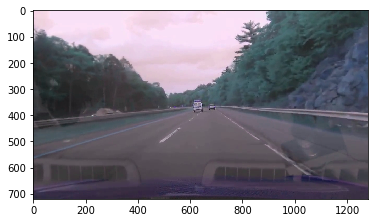

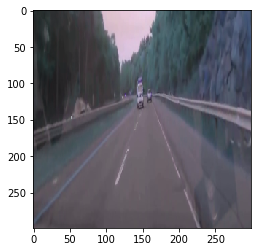

In [4]:
loadVideoAndResize(299, 299)

加载数据

In [97]:

def load_preprocess_training_batch(batch_id, resize_w, resize_h):
    filename = 'epoch{:0>2}_{}_{}_preprocess_train.p'.format(batch_id, resize_w, resize_h)
    img, steer = pickle.load(open(filename, mode='rb'))

    return img, steer
def load_preprocess_validating_batch(batch_id, resize_w, resize_h):
    filename = 'epoch{:0>2}_{}_{}_preprocess_val.p'.format(batch_id, resize_w, resize_h)
    img, steer = pickle.load(open(filename, mode='rb'))

    return img, steer

In [98]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
seed = 10

In [99]:
def nor_output(pre_y):
    pre = pre_y.reshape(1, -1)[0]
    for i, x in enumerate(pre):
        pre[i] = round(x, 4)

    for i,x in enumerate(pre):
        if x > 0:
            if (x-math.floor(x))>=0.75:
                pre[i] = int(x) + 1.0
            elif (x-math.floor(x))>=0.25:
                pre[i] = (int(x) + 0.5)
            else:
                pre[i] = int(x)
        else:
            if (x-int(x))<=-0.75:
                pre[i] = int(x) - 1.0
            elif (x-int(x))<=-0.25:
                pre[i] = (int(x) - 0.5)
            else:
                pre[i] = int(x)
    return pre

In [100]:
def simple_model_1(time_len=1):
    ch, row, col = 3, 64, 64  # camera format

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))
#  model.add(Lambda(nor_output_1))
    model.compile(loss='mean_absolute_error', optimizer='rmsprop')

      

    return model

In [150]:
def simple_model_2(time_len=1):
    ch, row, col = 3, 32, 32  # camera format

    model = Sequential()
    model.add(Lambda(lambda x: x/255.0,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
    model.add(Conv2D(128,kernel_size =(3,3), strides=(1, 1), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(256,kernel_size =(1,1), strides=(1, 1), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(384,kernel_size =(9,9), strides=(1, 1), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(512,kernel_size =(1,1), strides=(1, 1), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Flatten())
      
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.6))
    model.add(Dense(1))

    model.compile(loss='mean_absolute_error', optimizer='sgd')

      

    return model

In [7]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
def inceptionV3_model(time_len=1):
# create the base pre-trained model 299 * 299
    base_model = InceptionV3(weights='imagenet', include_top=True)

# add a global spatial average pooling layer
    x = base_model.output
 #   x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
  #  x = Dense(1, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
    predictions = Dense(1)(x)

# this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='sgd', loss='mean_absolute_error')

# train the model on the new data for a few epochs
    

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
 #   for i, layer in enumerate(base_model.layers):
 #       print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
  #  for layer in model.layers[:249]:
  #      layer.trainable = False
  #  for layer in model.layers[249:]:
  #      layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
   # from keras.optimizers import SGD
   # model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='mean_absolute_error')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
   # model.fit_generator(...)
    return model

In [16]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

def restNet_model(time_len=1):
    #224 * 224
    base_model = ResNet50(weights='imagenet')

    x = base_model.output
    predictions = Dense(1)(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='sgd', loss='mean_absolute_error')
  #  for i, layer in enumerate(base_model.layers):
     #   print(i, layer.name)
    return model

In [120]:
batch_size = 64
epoches = 50

In [117]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math
from decimal import Decimal
def train_model(video_list, model_func, resize_w, resize_h, ifSave = False, test_img=None, test_y=None):
    model = model_func()
    ######
  #  for epoch_idx in range(1, (len(video_list) * epoches) + 1) :
  #      
  #      video_idx = epoch_idx % len(video_list)
  #      if video_idx == 0:
  #          video_idx = len(video_list)
  #      print("train epoch_idx {} video_idx{}".format(epoch_idx, video_idx))
  #      x_train, y_train = load_preprocess_training_batch(video_idx, resize_w, resize_h)
  #      x_train = np.array(x_train).transpose(0, 2, 1, 3)
  #      model.fit(x_train, y_train, nb_epoch = 1, batch_size = batch_size)
    ######
  #  X = np.array([])
  #  Y = []
  #  for video_idx in range(1, len(video_list) + 1):
  #      x_train, y_train = load_preprocess_training_batch(video_idx, resize_w, resize_h)
  #      x_train = np.array(x_train).transpose(0,  1, 2, 3)
  #      #其它是0321, interceptv3:0123
  #      if X.shape == np.array([]).shape:
  #          X = x_train
  #          Y = list(y_train)
  #      else:
  #          X = np.vstack((X, x_train))
  #          Y.extend(list(y_train))
  ########   
    
    val_acc = []
    test_acc = []
    for epoch_idx in range(0, epoches):
        
        x_val = np.array([])
        y_val = []
        for video_idx in range(1, len(video_list) + 1):
            x_train, y_train = load_preprocess_training_batch(video_idx, resize_w, resize_h)
            x_train = np.array(x_train).transpose(0, 3, 2, 1)
            #随机打乱数据，取10%的训练数据做验证集
            img_list_train, img_list_val, steer_list_train, steer_list_val = train_test_split(x_train, np.array(y_train), test_size=0.1, random_state=10) 
            model.fit(img_list_train, steer_list_train, nb_epoch = 1, batch_size = batch_size)
            if x_val.shape == np.array([]).shape:
                x_val = img_list_val
                y_val = list(steer_list_val)
            else:
                x_val = np.vstack((x_val, img_list_val))
                y_val.extend(list(steer_list_val))
        val_acc.append(test_model(model, x_val, y_val))
        if test_img != None:
            test_acc.append(test_model(model, test_img, test_y))
    if ifSave == True:
        utils.save_model(model)
        
    plt.plot(val_acc,color='b', label='验证准确率')
    plt.plot(test_acc, color='g', label='测试准确率')
    plt.show()
    return model

In [118]:
def test_model(model, img_list_val, y_val):
    pre = model.predict(img_list_val,  verbose=0)
    pre = nor_output(pre)
  #  print (pre)
    score = r2_score(y_val, pre)
    print("score: %.2f " % (score))
    

    if type(y_val) != np.array:
        y_val = np.array(y_val)
    y_val = y_val.reshape(len(list(y_val)), 1)    
    y_val = y_val.reshape(1, -1)[0]
    x = np.arange(1, len(y_val) + 1)
    y = y_val  - pre ;

    plt.plot(x, abs(y) , marker = '.', color = 'b', label = 'steer bias',linewidth=0.1)
    plt.show()
    return score

训练单个视频

In [122]:
res_w = 32
res_h = 32
x_test, y_test = load_preprocess_training_batch(10, res_w, res_h)   
x_test = np.array(x_test).transpose(0, 3, 2, 1)

In [16]:
#img_val, steer_val = load_preprocess_validating_batch(1, res_w, res_h)
#img_val = np.array(img_val).transpose(0, 3, 2, 1)

model_single = train_model([1],  inceptionV3_model, res_w, res_h, ifSave = True)
test_model(model_single, x_test, y_test)

/Users/apple/.keras/models/inception_v3_weights_tf_dim_ordering_tf_kernels.h5


/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/5


KeyboardInterrupt: 

训练全部视频

/Users/sengled/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
1350/1350 [==============================] - 53s 39ms/step - loss: 2.6454
Epoch 1/1
3510/3510 [==============================] - 131s 37ms/step - loss: 1.3725
Epoch 1/1
2430/2430 [==============================] - 88s 36ms/step - loss: 1.4493
Epoch 1/1
2430/2430 [==============================] - 89s 36ms/step - loss: 7.5253
Epoch 1/1
2430/2430 [==============================] - 88s 36ms/step - loss: 3.5245
Epoch 1/1
2430/2430 [==============================] - 88s 36ms/step - loss: 4.5185
Epoch 1/1
2430/2430 [==============================] - 89s 36ms/step - loss: 2.4926
Epoch 1/1
2430/2430 [==============================] - 88s 36ms/step - loss: 3.3263
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 1.1852
score: -0.04 


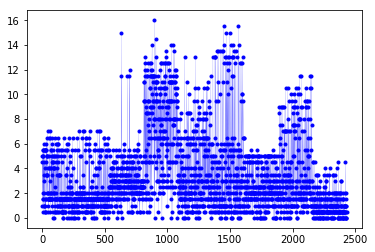

/Users/sengled/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:51: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


score: -0.02 


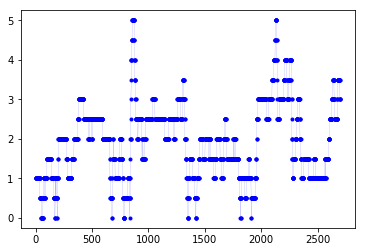

Epoch 1/1
1350/1350 [==============================] - 49s 36ms/step - loss: 2.6429
Epoch 1/1
3510/3510 [==============================] - 128s 37ms/step - loss: 1.3809
Epoch 1/1
2430/2430 [==============================] - 89s 36ms/step - loss: 1.4318
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 7.4873
Epoch 1/1
2430/2430 [==============================] - 89s 36ms/step - loss: 3.0956
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 4.4752
Epoch 1/1
2430/2430 [==============================] - 89s 36ms/step - loss: 2.3719
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 3.1751
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 1.0588
score: 0.05 


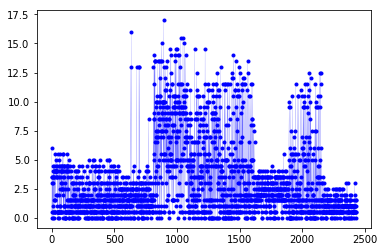

score: 0.08 


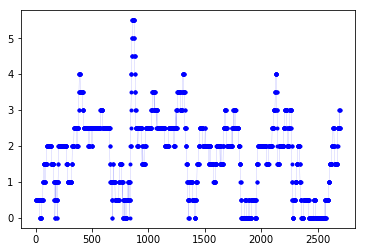

Epoch 1/1
1350/1350 [==============================] - 49s 37ms/step - loss: 2.3716
Epoch 1/1
3510/3510 [==============================] - 128s 36ms/step - loss: 1.2940
Epoch 1/1
2430/2430 [==============================] - 89s 36ms/step - loss: 1.4310
Epoch 1/1
2430/2430 [==============================] - 88s 36ms/step - loss: 7.3091
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 2.9814
Epoch 1/1
2430/2430 [==============================] - 88s 36ms/step - loss: 4.2418
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 1.7473
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 2.9406
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 0.9543
score: 0.07 


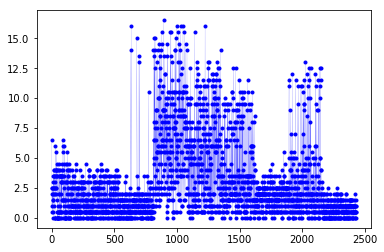

score: 0.23 


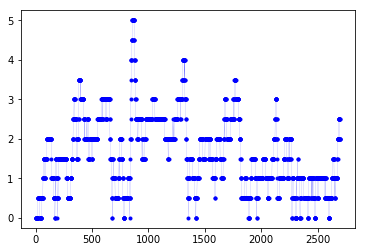

Epoch 1/1
1350/1350 [==============================] - 49s 36ms/step - loss: 2.1642
Epoch 1/1
3510/3510 [==============================] - 138s 39ms/step - loss: 1.1201
Epoch 1/1
2430/2430 [==============================] - 92s 38ms/step - loss: 1.4153
Epoch 1/1
2430/2430 [==============================] - 91s 37ms/step - loss: 6.8280
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 2.9438
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 3.8770
Epoch 1/1
2430/2430 [==============================] - 98s 40ms/step - loss: 1.4295
Epoch 1/1
2430/2430 [==============================] - 93s 38ms/step - loss: 2.6908
Epoch 1/1
2430/2430 [==============================] - 92s 38ms/step - loss: 0.9084
score: 0.12 


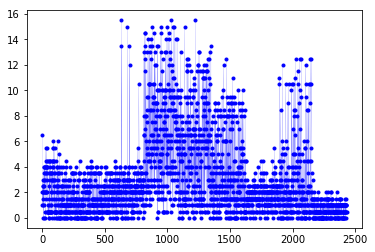

score: 0.30 


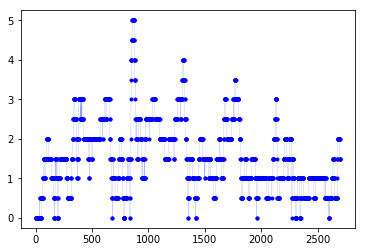

Epoch 1/1
1350/1350 [==============================] - 51s 37ms/step - loss: 2.1069
Epoch 1/1
3510/3510 [==============================] - 131s 37ms/step - loss: 0.9718
Epoch 1/1
2430/2430 [==============================] - 90s 37ms/step - loss: 1.4064
Epoch 1/1
2430/2430 [==============================] - 90s 37ms/step - loss: 6.0814
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 2.6433
Epoch 1/1
2430/2430 [==============================] - 90s 37ms/step - loss: 3.4842
Epoch 1/1
2430/2430 [==============================] - 90s 37ms/step - loss: 1.2858
Epoch 1/1
2430/2430 [==============================] - 90s 37ms/step - loss: 2.5547
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 0.8469
score: 0.17 


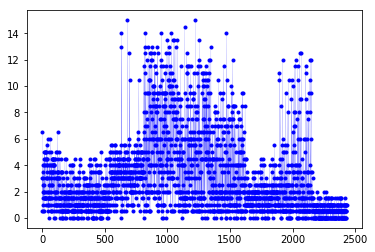

score: 0.39 


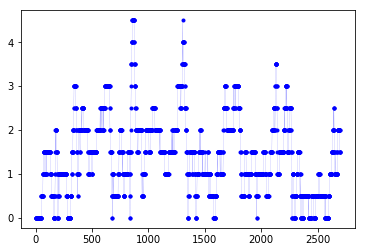

Epoch 1/1
1350/1350 [==============================] - 50s 37ms/step - loss: 2.0955
Epoch 1/1
3510/3510 [==============================] - 131s 37ms/step - loss: 0.8759
Epoch 1/1
2430/2430 [==============================] - 88s 36ms/step - loss: 1.3731
Epoch 1/1
2430/2430 [==============================] - 98s 40ms/step - loss: 4.9902
Epoch 1/1
2430/2430 [==============================] - 100s 41ms/step - loss: 2.3250
Epoch 1/1
2430/2430 [==============================] - 93s 38ms/step - loss: 3.2100
Epoch 1/1
2430/2430 [==============================] - 93s 38ms/step - loss: 1.1508
Epoch 1/1
2430/2430 [==============================] - 117s 48ms/step - loss: 2.4579
Epoch 1/1
2430/2430 [==============================] - 102s 42ms/step - loss: 0.8122
score: 0.20 


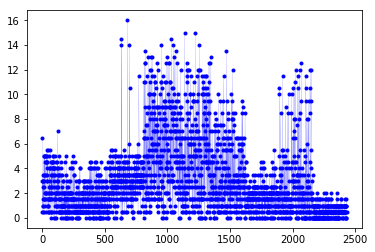

score: 0.27 


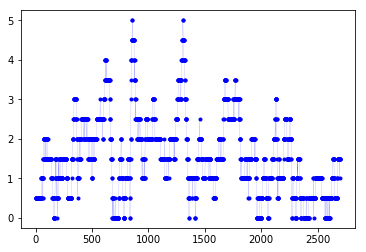

Epoch 1/1
1350/1350 [==============================] - 49s 36ms/step - loss: 2.0208
Epoch 1/1
3510/3510 [==============================] - 127s 36ms/step - loss: 0.8473
Epoch 1/1
2430/2430 [==============================] - 94s 39ms/step - loss: 1.3134
Epoch 1/1
2430/2430 [==============================] - 96s 39ms/step - loss: 4.0514
Epoch 1/1
2430/2430 [==============================] - 98s 40ms/step - loss: 2.2552
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 2.8677
Epoch 1/1
2430/2430 [==============================] - 93s 38ms/step - loss: 1.1332
Epoch 1/1
2430/2430 [==============================] - 99s 41ms/step - loss: 2.3200
Epoch 1/1
2430/2430 [==============================] - 100s 41ms/step - loss: 0.7575
score: 0.26 


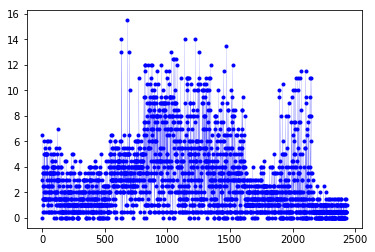

score: 0.44 


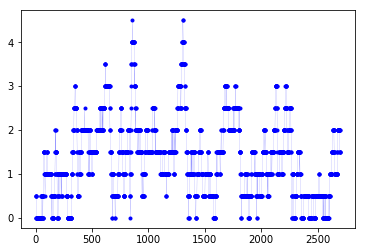

Epoch 1/1
1350/1350 [==============================] - 56s 42ms/step - loss: 1.9179
Epoch 1/1
3510/3510 [==============================] - 130s 37ms/step - loss: 0.7226
Epoch 1/1
2430/2430 [==============================] - 102s 42ms/step - loss: 1.2525
Epoch 1/1
2430/2430 [==============================] - 90s 37ms/step - loss: 3.3822
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 2.0552
Epoch 1/1
2430/2430 [==============================] - 94s 39ms/step - loss: 2.5680
Epoch 1/1
2430/2430 [==============================] - 99s 41ms/step - loss: 1.1348
Epoch 1/1
2430/2430 [==============================] - 109s 45ms/step - loss: 2.1502
Epoch 1/1
2430/2430 [==============================] - 96s 40ms/step - loss: 0.7661
score: 0.30 


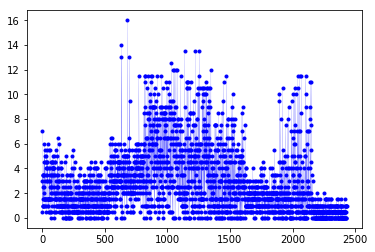

score: 0.38 


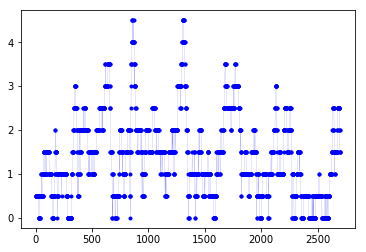

Epoch 1/1
1350/1350 [==============================] - 51s 37ms/step - loss: 1.7702
Epoch 1/1
3510/3510 [==============================] - 140s 40ms/step - loss: 0.6809
Epoch 1/1
2430/2430 [==============================] - 91s 38ms/step - loss: 1.2554
Epoch 1/1
2430/2430 [==============================] - 92s 38ms/step - loss: 2.8256
Epoch 1/1
2430/2430 [==============================] - 102s 42ms/step - loss: 1.9636
Epoch 1/1
2430/2430 [==============================] - 93s 38ms/step - loss: 2.3405
Epoch 1/1
2430/2430 [==============================] - 95s 39ms/step - loss: 1.1208
Epoch 1/1
2430/2430 [==============================] - 90s 37ms/step - loss: 2.0165
Epoch 1/1
2430/2430 [==============================] - 90s 37ms/step - loss: 0.7419
score: 0.36 


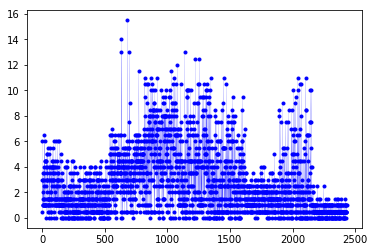

score: 0.47 


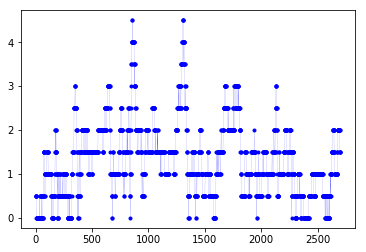

Epoch 1/1
1350/1350 [==============================] - 54s 40ms/step - loss: 1.5758
Epoch 1/1
3510/3510 [==============================] - 142s 40ms/step - loss: 0.6018
Epoch 1/1
2430/2430 [==============================] - 97s 40ms/step - loss: 1.1754
Epoch 1/1
2430/2430 [==============================] - 98s 40ms/step - loss: 2.3545
Epoch 1/1
2430/2430 [==============================] - 99s 41ms/step - loss: 1.7812
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 1.9778
Epoch 1/1
2430/2430 [==============================] - 87s 36ms/step - loss: 1.0580
Epoch 1/1
2430/2430 [==============================] - 99s 41ms/step - loss: 1.8326
Epoch 1/1
2430/2430 [==============================] - 96s 39ms/step - loss: 0.7146
score: 0.37 


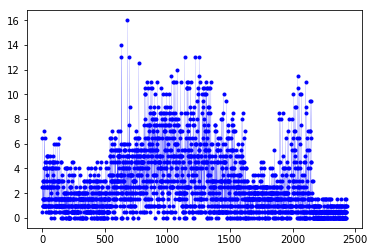

score: 0.28 


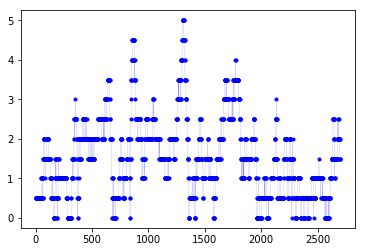

Epoch 1/1
1350/1350 [==============================] - 52s 39ms/step - loss: 1.3993
Epoch 1/1
3510/3510 [==============================] - 131s 37ms/step - loss: 0.5656
Epoch 1/1
2430/2430 [==============================] - 95s 39ms/step - loss: 1.1434
Epoch 1/1
2430/2430 [==============================] - 92s 38ms/step - loss: 2.1301
Epoch 1/1
2430/2430 [==============================] - 92s 38ms/step - loss: 1.7532
Epoch 1/1
2430/2430 [==============================] - 90s 37ms/step - loss: 1.7660
Epoch 1/1
2430/2430 [==============================] - 98s 40ms/step - loss: 1.0456
Epoch 1/1
2430/2430 [==============================] - 90s 37ms/step - loss: 1.7014
Epoch 1/1
2430/2430 [==============================] - 87s 36ms/step - loss: 0.6903
score: 0.40 


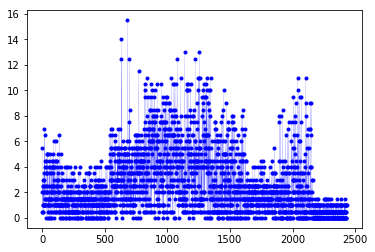

score: 0.28 


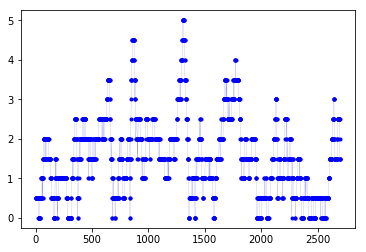

Epoch 1/1
1350/1350 [==============================] - 51s 38ms/step - loss: 1.1994
Epoch 1/1
3510/3510 [==============================] - 139s 40ms/step - loss: 0.5387
Epoch 1/1
2430/2430 [==============================] - 89s 37ms/step - loss: 1.0852
Epoch 1/1
2430/2430 [==============================] - 89s 36ms/step - loss: 1.9127
Epoch 1/1
2430/2430 [==============================] - 90s 37ms/step - loss: 1.6477
Epoch 1/1
2430/2430 [==============================] - 94s 39ms/step - loss: 1.5814
Epoch 1/1
2430/2430 [==============================] - 95s 39ms/step - loss: 0.9050
Epoch 1/1
2430/2430 [==============================] - 91s 37ms/step - loss: 1.5893
Epoch 1/1
2430/2430 [==============================] - 88s 36ms/step - loss: 0.6683
score: 0.44 


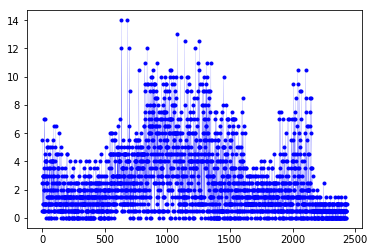

score: 0.49 


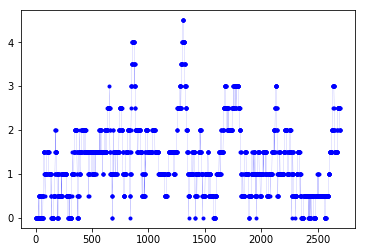

Epoch 1/1
1350/1350 [==============================] - 51s 38ms/step - loss: 1.1010
Epoch 1/1
3510/3510 [==============================] - 135s 38ms/step - loss: 0.4978
Epoch 1/1
2430/2430 [==============================] - 98s 40ms/step - loss: 1.0333
Epoch 1/1
2430/2430 [==============================] - 96s 39ms/step - loss: 1.7681
Epoch 1/1
2430/2430 [==============================] - 96s 40ms/step - loss: 1.4619
Epoch 1/1
2430/2430 [==============================] - 91s 37ms/step - loss: 1.5188
Epoch 1/1
2430/2430 [==============================] - 100s 41ms/step - loss: 0.8785
Epoch 1/1
2430/2430 [==============================] - 95s 39ms/step - loss: 1.4613
Epoch 1/1
2430/2430 [==============================] - 101s 41ms/step - loss: 0.6566
score: 0.44 


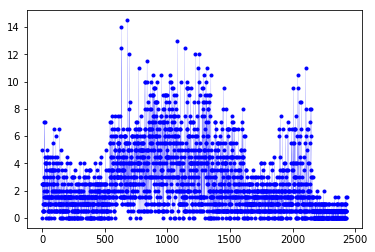

score: 0.48 


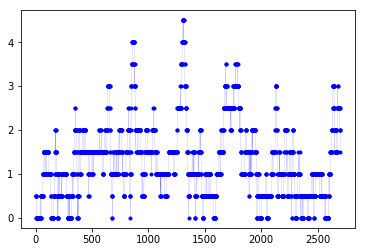

Epoch 1/1
1350/1350 [==============================] - 49s 36ms/step - loss: 1.0464
Epoch 1/1
3510/3510 [==============================] - 131s 37ms/step - loss: 0.4940
Epoch 1/1
2430/2430 [==============================] - 99s 41ms/step - loss: 1.0097
Epoch 1/1
2430/2430 [==============================] - 99s 41ms/step - loss: 1.6154
Epoch 1/1
2430/2430 [==============================] - 95s 39ms/step - loss: 1.3841
Epoch 1/1
2430/2430 [==============================] - 105s 43ms/step - loss: 1.3508
Epoch 1/1
2430/2430 [==============================] - 107s 44ms/step - loss: 0.8587
Epoch 1/1
2430/2430 [==============================] - 98s 40ms/step - loss: 1.3154
Epoch 1/1
1664/2430 [===================>..........] - ETA: 32s - loss: 0.6920

In [ ]:
model_all = train_model(range(1, 10),  simple_model_2, res_w, res_h, ifSave = True, test_img = x_test, test_y = y_test)
test_model(model_all, x_test, y_test)